## **3. MODELOS**

### **Librerias y funciones**

In [1]:
import pandas as pd
import Funciones as funciones
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import joblib
from sklearn.preprocessing import StandardScaler

### **Lectura de datos**

In [2]:
df_final=("DATA/df_final.csv")  
df_final=pd.read_csv(df_final)
df = df_final.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   BusinessTravel           4410 non-null   object 
 2   Department               4410 non-null   object 
 3   DistanceFromHome         4410 non-null   int64  
 4   Education                4410 non-null   int64  
 5   EducationField           4410 non-null   object 
 6   EmployeeID               4410 non-null   int64  
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   int64  
 12  NumCompaniesWorked       4410 non-null   float64
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

### **Imputación de variables**

- **Variables numéricas**

_Se elimina las variables `resignationReason` ya que se encuentra en el mismo periodo de tiempo que la variable respuesta, es por esto que esta variable tiene correlacion con la variable Atrittion, lo cual sesga el desempeño de los modelos._ 

In [3]:
df1=df.drop(columns=["retirementDate","resignationReason"])
df1.columns

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'Attrition'],
      dtype='object')

- **Variables categóricas**

In [4]:
list_cat=['BusinessTravel', 'Department', 'Gender', 
          'JobRole', 'MaritalStatus', 'EducationField']

df1=funciones.imputar_f(df1,list_cat)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   BusinessTravel  4410 non-null   object
 1   Department      4410 non-null   object
 2   Gender          4410 non-null   object
 3   JobRole         4410 non-null   object
 4   MaritalStatus   4410 non-null   object
 5   EducationField  4410 non-null   object
dtypes: object(6)
memory usage: 206.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   float64
 1   DistanceFromHome         4410 non-null   float64
 2   Education                4410 non-null   float64
 3   EmployeeID               4410 non-null   float64
 4   JobLevel                 4410 non-null   float64
 5   MonthlyInc

### **Conversión a dummies**

In [5]:
list_dummies=['BusinessTravel', 'Department', 'Gender', 
          'JobRole', 'MaritalStatus', 'EducationField']


df_dummies=pd.get_dummies(df1,columns=list_dummies)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   float64
 1   DistanceFromHome                   4410 non-null   float64
 2   Education                          4410 non-null   float64
 3   EmployeeID                         4410 non-null   float64
 4   JobLevel                           4410 non-null   float64
 5   MonthlyIncome                      4410 non-null   float64
 6   NumCompaniesWorked                 4410 non-null   float64
 7   PercentSalaryHike                  4410 non-null   float64
 8   StockOptionLevel                   4410 non-null   float64
 9   TotalWorkingYears                  4410 non-null   float64
 10  TrainingTimesLastYear              4410 non-null   float64
 11  YearsAtCompany                     4410 non-null   float

### **Matriz de Correlacion**

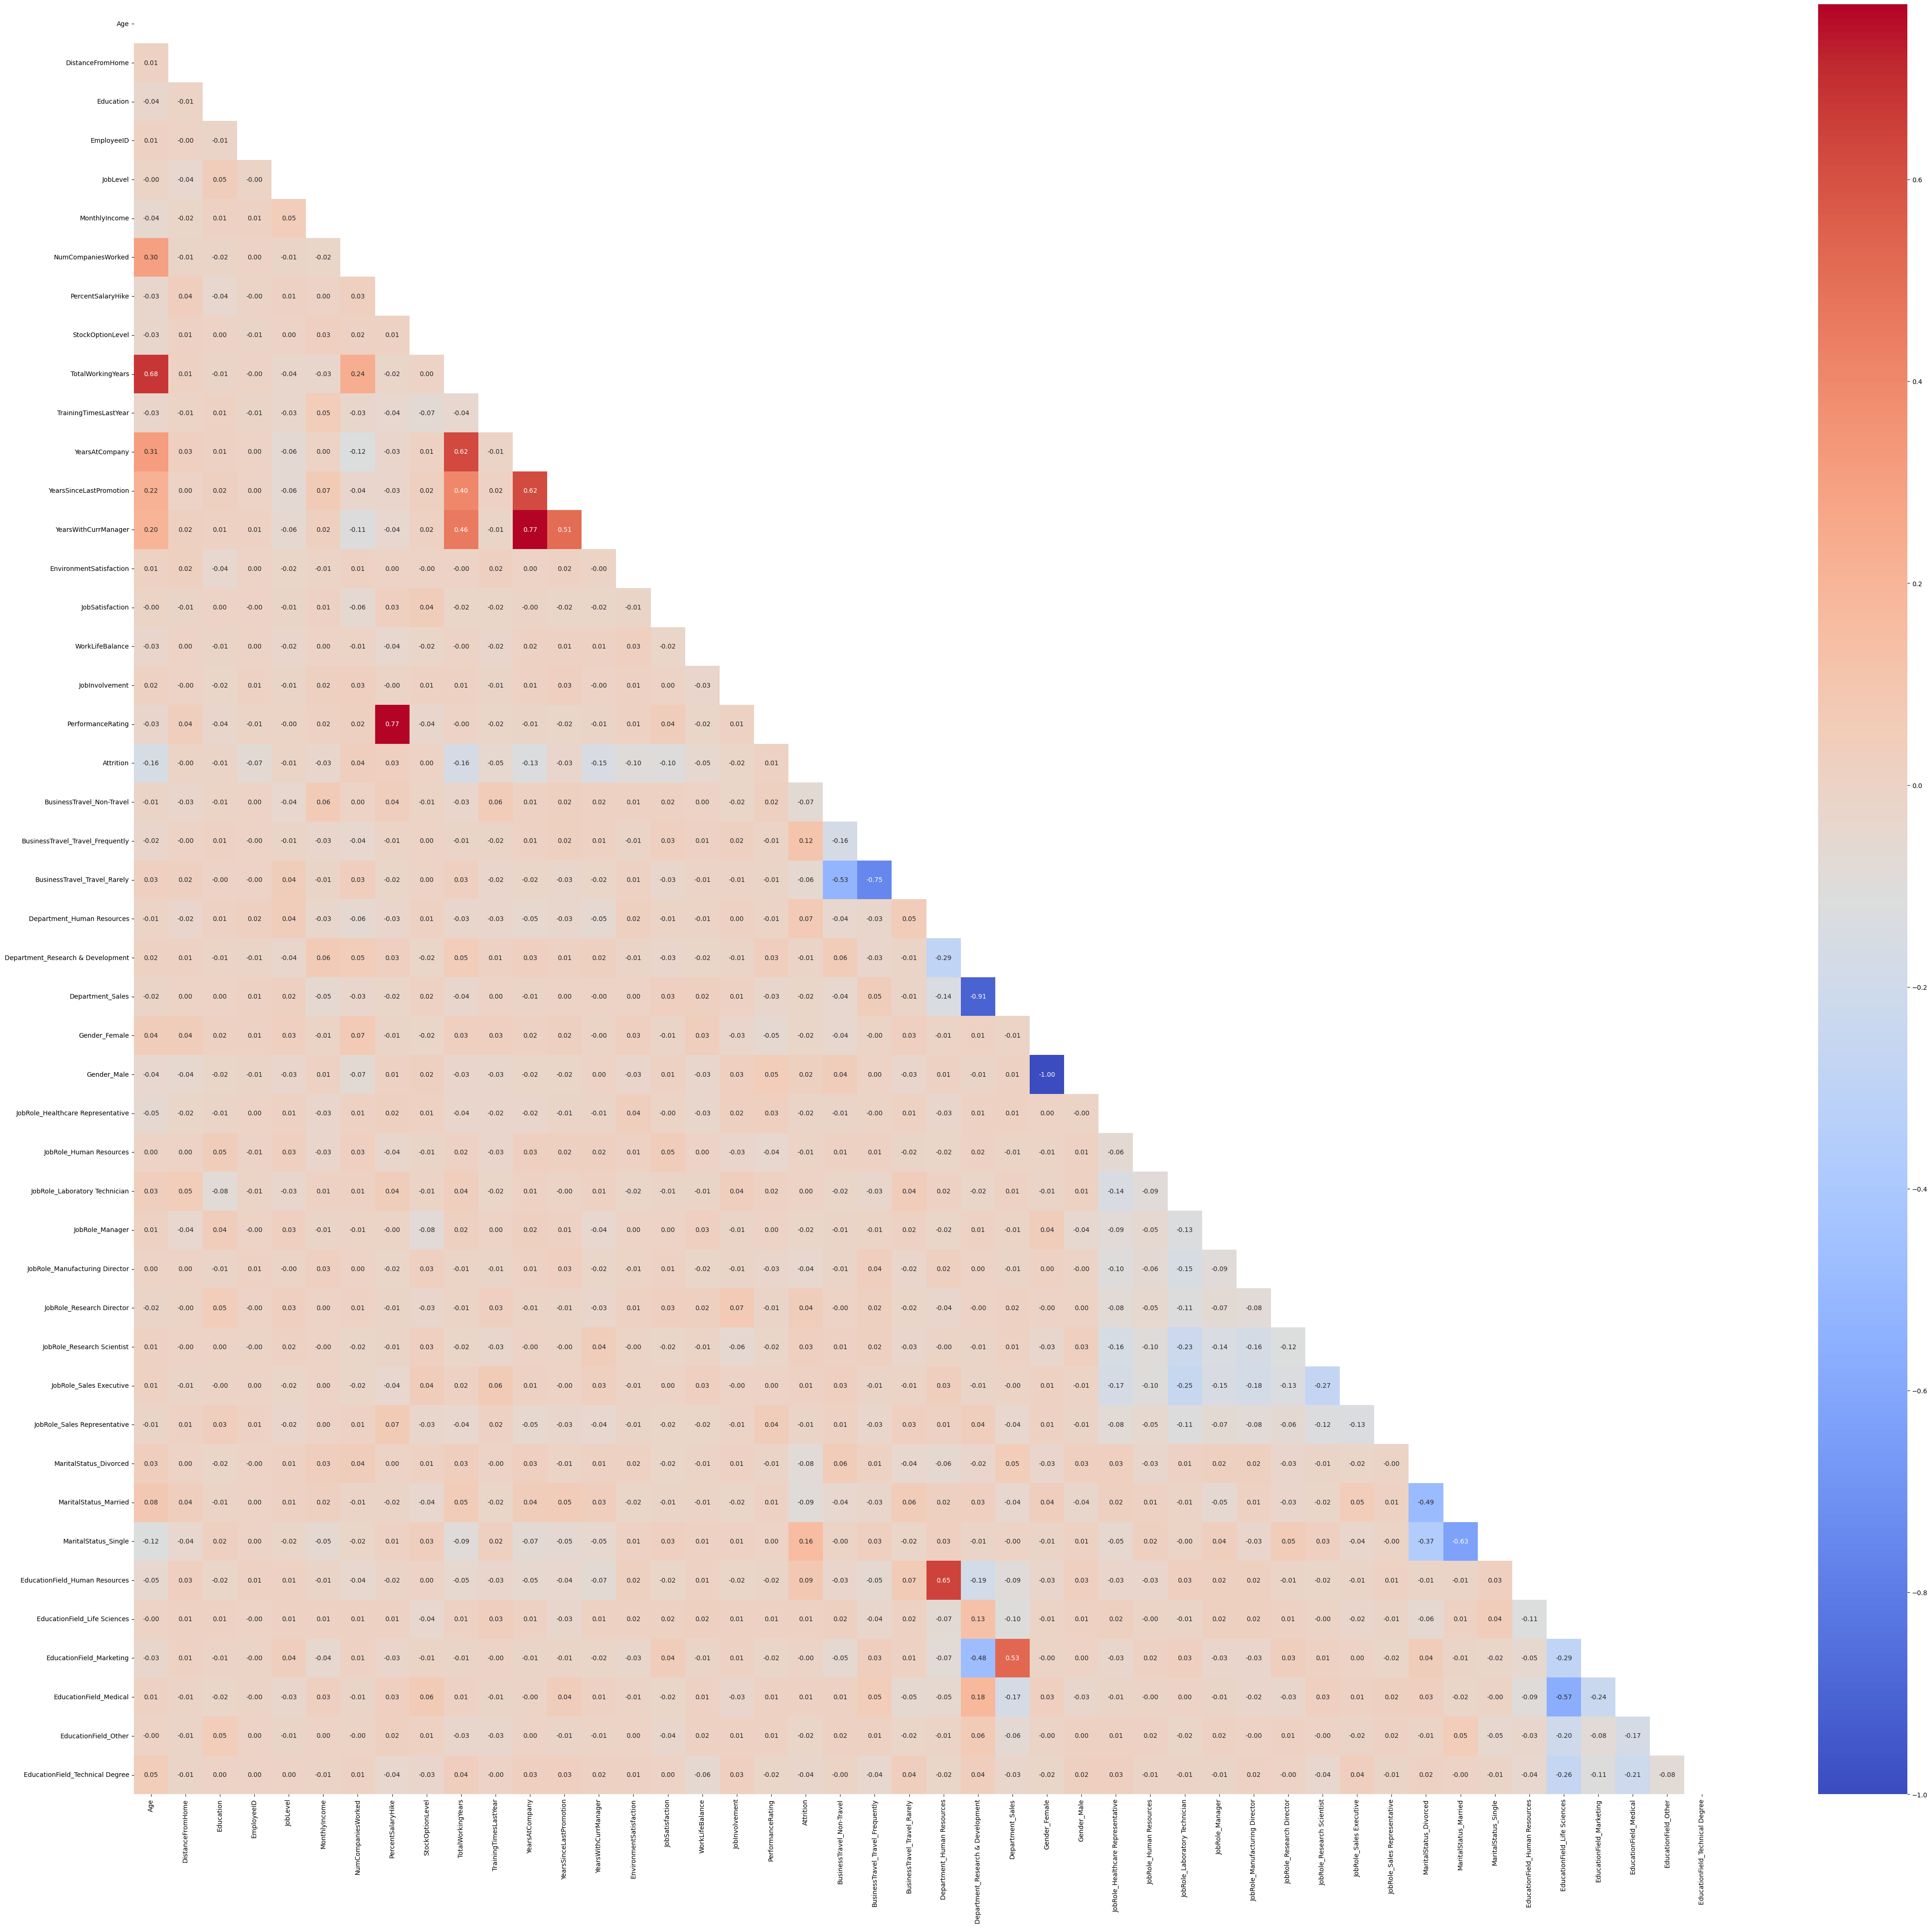

In [6]:
correlation_matrix = df_dummies.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(55, 50))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

### **Selección de variables**

- **Bajo criterio** 

El anterior paso permitió identificar variables altamente correlacionadas, estas se eliminarán con el objetivo de ayudar a prevenir multicolinealidad y mejorar el rendimiento del modelo.

In [7]:
y=df_dummies.Attrition
X1= df_dummies.loc[:,~df_dummies.columns.isin(['Attrition',
                                               'EmployeeID',
                                               'resignationReason_NoRetirement',
                                               'resignationReason_Others',
                                               'resignationReason_Salary',
                                               'resignationReason_Stress'])]

- **Escalado de características numéricas**

In [8]:
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)

- **Definición de modelos**

In [9]:
m_lreg = LogisticRegression()
m_rtree = tree.DecisionTreeClassifier()  
m_rf = RandomForestClassifier()  
m_gbt = GradientBoostingClassifier()  

modelos=list([m_lreg,m_rtree, m_rf, m_gbt])

- **Selección de variables usando la función**

In [10]:
var_names=funciones.sel_variables(modelos,X,y,threshold="2.5*mean")
var_names.shape

(9,)

- **Variables seleccionadas**

In [11]:
X2=X[var_names] 
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   float64
 1   DistanceFromHome         4410 non-null   float64
 2   EnvironmentSatisfaction  4410 non-null   float64
 3   JobSatisfaction          4410 non-null   float64
 4   MonthlyIncome            4410 non-null   float64
 5   NumCompaniesWorked       4410 non-null   float64
 6   TotalWorkingYears        4410 non-null   float64
 7   YearsSinceLastPromotion  4410 non-null   float64
 8   YearsWithCurrManager     4410 non-null   float64
dtypes: float64(9)
memory usage: 310.2 KB


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   float64
 1   DistanceFromHome                   4410 non-null   float64
 2   Education                          4410 non-null   float64
 3   JobLevel                           4410 non-null   float64
 4   MonthlyIncome                      4410 non-null   float64
 5   NumCompaniesWorked                 4410 non-null   float64
 6   PercentSalaryHike                  4410 non-null   float64
 7   StockOptionLevel                   4410 non-null   float64
 8   TotalWorkingYears                  4410 non-null   float64
 9   TrainingTimesLastYear              4410 non-null   float64
 10  YearsAtCompany                     4410 non-null   float64
 11  YearsSinceLastPromotion            4410 non-null   float

### **Modelo K fold cross validation**

- **Evaluación parametro F1** - Puntuacion de precision y sensibilidad

In [13]:
f1_df = funciones.medir_modelos(modelos, "f1", X, y, 4)
f1_varsel = funciones.medir_modelos(modelos, "f1", X2, y, 4) #Variables seleccionadas
F1=pd.concat([f1_df,f1_varsel],axis=1)
F1.columns=['rl', 'dt', 'rf', 'gb',
       'rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']
F1

,rl,dt,rf,gb,rl_Sel,dt_sel,rf_sel,gb_Sel
0,0.227979,0.996923,1.000000,0.605809,0.035714,0.981818,0.993865,0.463636
1,0.222222,0.764045,0.814545,0.439252,0.047337,0.769811,0.843972,0.330000
2,0.188482,0.764045,0.834532,0.423077,0.012195,0.765152,0.813187,0.351220
3,0.245283,0.839378,0.841558,0.561265,0.035928,0.836364,0.841558,0.474576


- **Evaluación Accuracy**

In [14]:
accuracy_df=funciones.medir_modelos(modelos,"accuracy",X,y,4) ## base con todas las variables #4: Número de grupos en que va a separar los datos para realizar el cross validation
accuracy_varsel=funciones.medir_modelos(modelos,"accuracy",X2,y,4) ### base con variables seleccionadas

accuracy=pd.concat([accuracy_df,accuracy_varsel],axis=1)
accuracy.columns=['rl', 'dt', 'rf', 'gb',
       'rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']
accuracy

,rl,dt,rf,gb,rl_Sel,dt_sel,rf_sel,gb_Sel
0,0.864914,0.999093,1.000000,0.913871,0.853128,0.993654,0.997280,0.893019
1,0.860381,0.942883,0.953762,0.891206,0.854034,0.944696,0.960109,0.878513
2,0.859347,0.943739,0.954628,0.891107,0.852995,0.943739,0.958258,0.879310
3,0.854809,0.943739,0.944646,0.899274,0.853902,0.941924,0.944646,0.887477


- **Comparacion de metricas por modelo**

In [15]:
# Tabla con promedio de métricas
average_metrics = pd.DataFrame({
    'Model': ['reg_lineal', 'decision_tree', 'random_forest', 'gradient_boosting'],
    'F1_Average': [F1['rl'].mean(), F1['dt'].mean(), F1['rf'].mean(), F1['gb'].mean()],
    'Accuracy_Average': [accuracy['rl'].mean(), accuracy['dt'].mean(), accuracy['rf'].mean(), accuracy['gb'].mean()]
})
average_metrics

,Model,F1_Average,Accuracy_Average
0,reg_lineal,0.220992,0.859863
1,decision_tree,0.841098,0.957363
2,random_forest,0.872659,0.963259
3,gradient_boosting,0.507351,0.898865


In [32]:
# Tabla con promedio de métricas segun Variables Seleccionadas
average_metrics_sel = pd.DataFrame({
    'Model': ['reg_lineal_sel', 'decision_tree_sel', 'random_forest_sel', 'gradient_boosting_sel'],
    'F1_Average': [F1['rl_Sel'].mean(), F1['dt_sel'].mean(), F1['rf_sel'].mean(), F1['gb_Sel'].mean()],
    'Accuracy_Average': [accuracy['rl_Sel'].mean(), accuracy['dt_sel'].mean(), accuracy['rf_sel'].mean(), accuracy['gb_Sel'].mean()]
})
average_metrics_sel

,Model,F1_Average,Accuracy_Average
0,reg_lineal_sel,0.032794,0.853515
1,decision_tree_sel,0.838286,0.956003
2,random_forest_sel,0.873145,0.965073
3,gradient_boosting_sel,0.404858,0.884580


<Axes: >

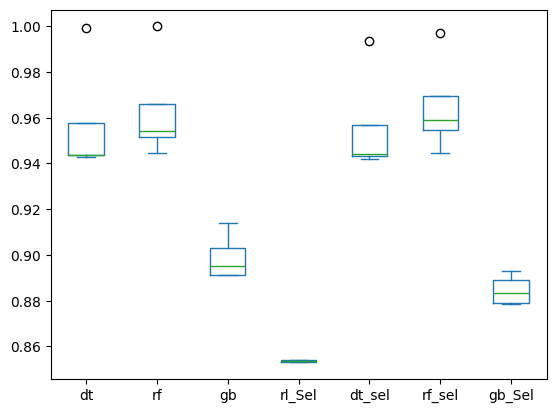

In [17]:
accuracy2=accuracy[ ['dt', 'rf', 'gb','rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']]
accuracy2.plot(kind='box') ### gráfico para modelos sel y todas las variables

<Axes: >

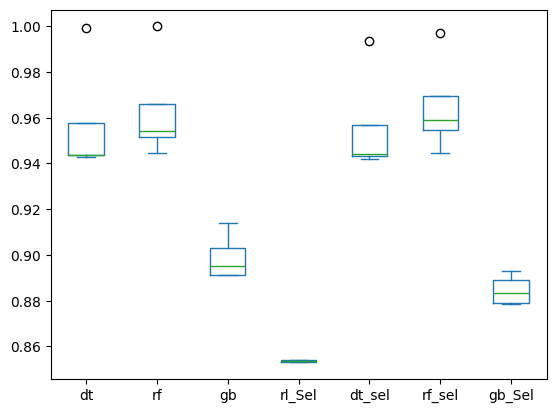

In [18]:

accuracy2=accuracy[ ['dt', 'rf', 'gb','rl_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']]
accuracy2.plot(kind='box') ### gráfico para modelos sel y todas las variables


Luego de la observación del desempeño de los modelos, se continua con arboles de decision y RandomForest.

### **Tuneo de hiperparametros**

- **Para Arboles de decisión**

In [19]:
param_grid = [{'max_depth': [3, 5, 7, 9, 11, None], 
               'min_samples_split': [2, 5, 10, 20], 
               'min_samples_leaf': [1, 5, 10, 20]}]

tun_rtree = RandomizedSearchCV(m_rtree, param_distributions=param_grid, n_iter=10, scoring="accuracy")
tun_rtree.fit(X2, y)

pd.set_option('display.max_colwidth', 100)
resultados = tun_rtree.cv_results_
print(tun_rtree.best_params_)
pd_resultados = pd.DataFrame(resultados)
display(pd_resultados[["params", "mean_test_score"]])
rtree_final = tun_rtree.best_estimator_ ### Guardar el modelo con hyperparameter tunning

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 11}


,params,mean_test_score
0,"{'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 9}",0.870522
1,"{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 7}",0.881633
2,"{'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 5}",0.864399
3,"{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 9}",0.897506
4,"{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 7}",0.876417
5,"{'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': None}",0.911565
6,"{'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': None}",0.884127
7,"{'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 11}",0.889796
8,"{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 11}",0.923810
9,"{'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': None}",0.872109


- **Para Random Forest**

In [20]:
param_grid = [{'n_estimators': [3, 500, 100], 'max_features': [5,20],
               'min_samples_split': [100, 20, 5]}]

tun_rf=RandomizedSearchCV(m_rf,param_distributions=param_grid,n_iter=10,scoring="accuracy")
tun_rf.fit(X2,y)
### se comenta porque toma mucho tiempo en ejecutar

pd.set_option('display.max_colwidth', 100)
resultados=tun_rf.cv_results_
tun_rf.best_params_
pd_resultados=pd.DataFrame(resultados)
pd_resultados[["params","mean_test_score"]].sort_values(by="mean_test_score", ascending=False)

rf_final=tun_rf.best_estimator_ ### Guardar el modelo con hyperparameter tunning
m_lreg=m_lreg.fit(X2,y)

### **Exportación del proyecto**

In [21]:
joblib.dump(rf_final, "salidas\\rf_final.pkl")
joblib.dump(m_lreg, "salidas\\m_lreg.pkl")
joblib.dump(rtree_final, "salidas\\rtree_final.pkl")
joblib.dump(list_cat, "salidas\\list_cat.pkl") ### para realizar imputacion
joblib.dump(list_dummies, "salidas\\list_dummies.pkl")  ### para convertir a dummies
joblib.dump(var_names, "salidas\\var_names.pkl")  ### para variables con que se entrena modelo
joblib.dump(scaler, "salidas\\scaler.pkl")


### funcion para cargar objeto guardado ###
rf_final = joblib.load("salidas\\rf_final.pkl")
m_lreg = joblib.load("salidas\\m_lreg.pkl")
rtree_final = joblib.load("salidas\\rtree_final.pkl")
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

list_cat=joblib.load("salidas\\list_cat.pkl")
list_dummies=joblib.load("salidas\\list_dummies.pkl")
var_names=joblib.load("salidas\\var_names.pkl")
scaler=joblib.load("salidas\\scaler.pkl") 

print(hasattr(rf_final, 'fit'))  # Si es True, rf_final tiene un método fit
print(hasattr(rtree_final, 'fit'))  # Si es True, rtree_final tiene un método fit
print(hasattr(m_lreg, 'fit'))  # Si es True, m_lreg tiene un método fit


True
True
True


### **Evaluación**

Métrica de entrenamiento y  para mirar sobre ajuste

In [22]:
eval=cross_validate(rf_final,X,y,cv=5,scoring="accuracy",return_train_score=True)
eval2=cross_validate(rtree_final,X,y,cv=5,scoring="accuracy",return_train_score=True)

### **Resultados para RL, RF y DTREE**

In [23]:
#### convertir resultado de evaluacion entrenamiento y evaluacion en data frame para RF
train_rf=pd.DataFrame(eval['train_score'])
test_rf=pd.DataFrame(eval['test_score'])
train_test_rf=pd.concat([train_rf, test_rf],axis=1)
train_test_rf.columns=['train_score','test_score']

#### convertir resultado de evaluacion entrenamiento y evaluacion en data frame para RTree
train_rtree=pd.DataFrame(eval2['train_score'])
test_rtree=pd.DataFrame(eval2['test_score'])
train_test_rtree=pd.concat([train_rtree, test_rtree],axis=1)
train_test_rtree.columns=['train_score','test_score']

Con cambio de variables 

In [24]:
train_test_rf

,train_score,test_score
0,0.982710,1.000000
1,0.982993,0.939909
2,0.982710,1.000000
3,0.982993,0.939909
4,1.000000,0.930839


In [25]:
train_test_rtree

,train_score,test_score
0,0.960034,0.967120
1,0.965420,0.909297
2,0.957200,0.968254
3,0.966553,0.913832
4,0.957200,0.896825


In [26]:
train_test_rf["test_score"].mean()

0.9621315192743763

In [27]:
train_test_rtree["test_score"].mean()

0.9310657596371883

### **Importancia de variables**

In [28]:
pd.set_option('display.max_rows', 100)

- **Random Forest**

In [29]:
pd.set_option('display.max_rows', 100)
importancia1=pd.DataFrame(rf_final.feature_names_in_)
importancia2=pd.DataFrame(rf_final.feature_importances_)
importancia=pd.concat([importancia1,importancia2],axis=1)
importancia.columns=["variable","peso"]
importancia.sort_values('peso')
importancia.sort_values(by=["peso"], ascending=False)

,variable,peso
4,MonthlyIncome,0.237298
0,Age,0.163812
6,TotalWorkingYears,0.144033
1,DistanceFromHome,0.125538
5,NumCompaniesWorked,0.081941
2,EnvironmentSatisfaction,0.069620
8,YearsWithCurrManager,0.062806
7,YearsSinceLastPromotion,0.060282
3,JobSatisfaction,0.054668


- **Arboles de decisión**

In [30]:
importancia1=pd.DataFrame( rtree_final.feature_names_in_)
importancia2=pd.DataFrame(rtree_final.feature_importances_)
importancia=pd.concat([importancia1,importancia2],axis=1)
importancia.columns=["variable","peso"]
importancia.sort_values('peso')
importancia.sort_values(by=["peso"], ascending=False)

,variable,peso
4,MonthlyIncome,0.218919
1,DistanceFromHome,0.165326
0,Age,0.159737
6,TotalWorkingYears,0.157645
5,NumCompaniesWorked,0.078607
3,JobSatisfaction,0.070717
7,YearsSinceLastPromotion,0.051841
2,EnvironmentSatisfaction,0.048713
8,YearsWithCurrManager,0.048494


### **Matriz de confusion con algoritmo RandomForest**

[[742  15]
 [ 22 103]]


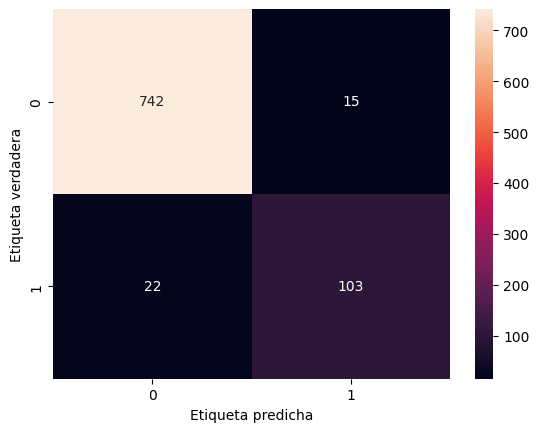

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')

plt.show()